<a href="https://colab.research.google.com/github/whitechocobread/Ai-project/blob/main/4%EC%A3%BC%EC%B0%A8/transfer_learning_tutorial_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline


# Transfer Learning for Computer Vision Tutorial
**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)

In this tutorial, you will learn how to train a convolutional neural network for
image classification using transfer learning. You can read more about the transfer
learning at [cs231n notes](https://cs231n.github.io/transfer-learning/)_

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the ConvNet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.


In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory


cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory.



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'drive/MyDrive/hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



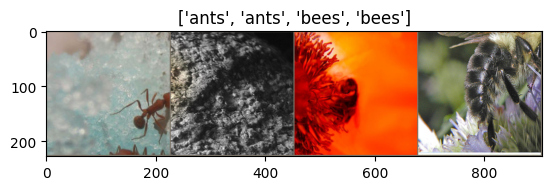

In [14]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        train_loss_history = []
        val_loss_history = []
        train_accuracy_history = []
        val_accuracy_history = []
        lr_history = []

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # 추가: 중간 정보 기록
                if phase == 'train':
                    train_loss_history.append(epoch_loss)
                    train_accuracy_history.append(epoch_acc.item())
                else:
                    val_loss_history.append(epoch_loss)
                    val_accuracy_history.append(epoch_acc.item())

                # 추가: 학습률(Learning Rate) 기록
                lr_history.append(optimizer.param_groups[0]['lr'])

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

        # 추가: 학습 정보 그래프 그리기
        plot_training_history(train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history, lr_history)

    return model


### Visualizing the model predictions

Generic function to display predictions for a few images




In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## **Finetuning the ConvNet**

Load a pretrained model and reset final fully connected layer.

 마지막 완전 연결 계층을 새로운 nn.Linear 계층으로 교체한다. 기존 모델의 학습된 특징을 가져와서 데이터에 맞는 새로운 출력 레이어를 추가하는 방식이다
 델을 새로운 작업에 맞게 Finetuning하고 모든 모델 파라미터가 학습된다



In [24]:
# 최종 완전 연결 계층을 재설정
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
#정리
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




Epoch 0/24
----------
train Loss: 0.5903 Acc: 0.6926
val Loss: 0.2463 Acc: 0.9020

Epoch 1/24
----------
train Loss: 0.3697 Acc: 0.8402
val Loss: 0.2770 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.5479 Acc: 0.8156
val Loss: 0.4365 Acc: 0.8497

Epoch 3/24
----------
train Loss: 0.4840 Acc: 0.7910
val Loss: 0.4175 Acc: 0.8562

Epoch 4/24
----------
train Loss: 0.5304 Acc: 0.7828
val Loss: 0.2552 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.4487 Acc: 0.8279
val Loss: 0.2514 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.3705 Acc: 0.8484
val Loss: 0.2855 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.3826 Acc: 0.8484
val Loss: 0.2818 Acc: 0.8824

Epoch 8/24
----------
train Loss: 0.3387 Acc: 0.8525
val Loss: 0.2921 Acc: 0.8954

Epoch 9/24
----------
train Loss: 0.3048 Acc: 0.8689
val Loss: 0.2377 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.2778 Acc: 0.8893
val Loss: 0.2440 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3334 Acc: 0.8607
val Loss: 0.2356 Acc: 0.9216

Ep

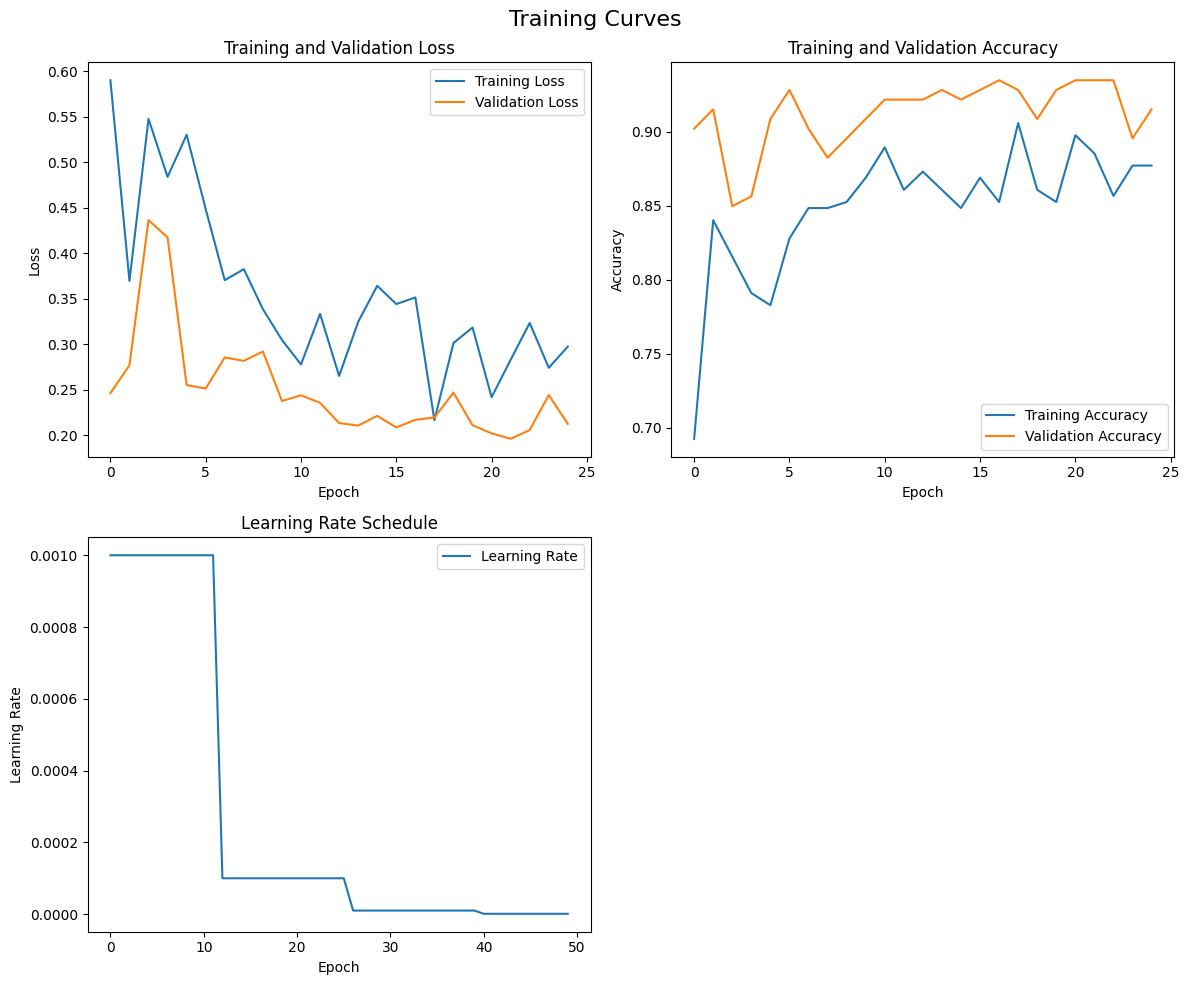

In [25]:
import matplotlib.pyplot as plt

def plot_training_history(train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history, lr_history):
    # 2x2 서브플롯 그리드를 생성합니다
    plt.figure(figsize=(12, 10))

    # 훈련 및 검증 손실에 대한 첫 번째 서브플롯을 생성합니다
    plt.subplot(2, 2, 1)
    plt.plot(range(len(train_loss_history)), train_loss_history, label='Training Loss')
    plt.plot(range(len(val_loss_history)), val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # 훈련 및 검증 정확도에 대한 두 번째 서브플롯을 생성합니다
    plt.subplot(2, 2, 2)
    plt.plot(range(len(train_accuracy_history)), train_accuracy_history, label='Training Accuracy')
    plt.plot(range(len(val_accuracy_history)), val_accuracy_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # 학습률(Learning Rate)에 대한 세 번째 서브플롯을 생성합니다
    plt.subplot(2, 2, 3)
    plt.plot(range(len(lr_history)), lr_history, label='Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.legend()

    # 전체 그래프에 제목 추가
    plt.suptitle('Training Curves', fontsize=16)

    plt.tight_layout()
    plt.show()

# 학습 진행
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

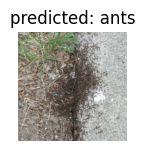

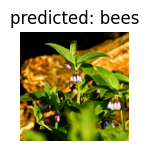

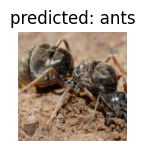

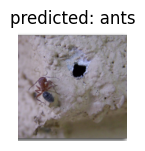

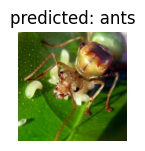

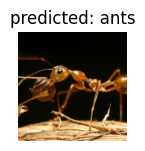

In [26]:
#시각
visualize_model(model_ft)

# **early stop일 경우**

Early stopping triggered. Stopped at epoch 14


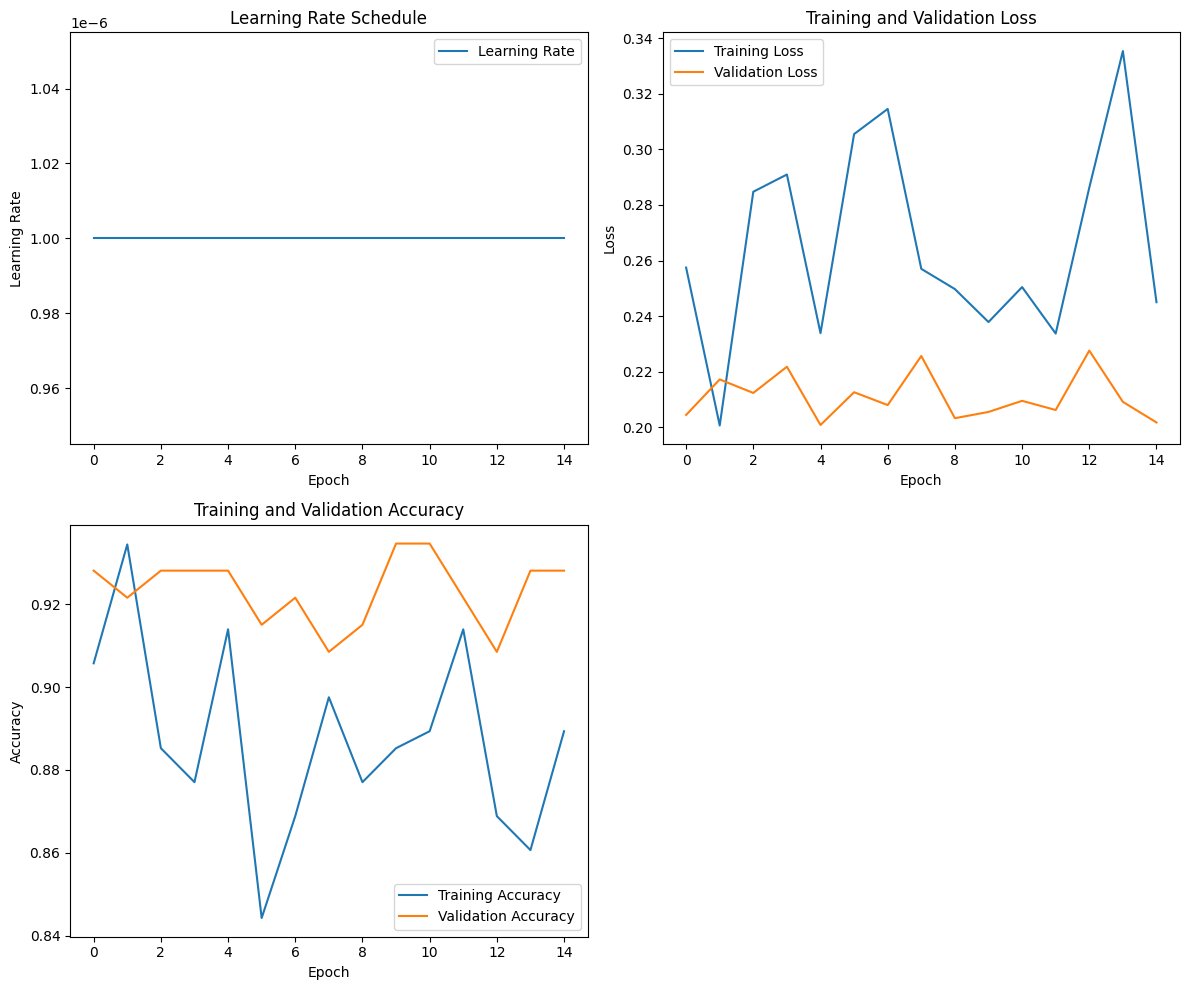

In [31]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Initialize lists to track metrics
lr_history = []
train_loss_history = []
val_loss_history = []
train_accuracy_history = []
val_accuracy_history = []

# Specify the number of epochs and early stopping parameters
num_epochs = 25
early_stopping_patience = 10
early_stopping_counter = 0
best_val_loss = float('inf')
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

for epoch in range(num_epochs):
    model_ft.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloaders['train']:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_ft.zero_grad()

        # Forward pass
        outputs = model_ft(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer_ft.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = running_loss / dataset_sizes['train']
    train_accuracy = correct / total

    # Record learning rate, training loss, and accuracy
    lr_history.append(optimizer_ft.param_groups[0]['lr'])
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    # Validation loop
    model_ft.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model_ft(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy
    val_loss = val_loss / dataset_sizes['val']
    val_accuracy = val_correct / val_total

    # Record validation loss and accuracy
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= early_stopping_patience:
        print(f"Early stopping triggered. Stopped at epoch {epoch}")
        break

# 2x2 subplot grid
plt.figure(figsize=(12, 10))

# Create the first subplot for the learning rate
plt.subplot(2, 2, 1)
plt.plot(range(len(lr_history)), lr_history, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()

# Create the second subplot for training and validation loss
plt.subplot(2, 2, 2)
plt.plot(range(len(train_loss_history)), train_loss_history, label='Training Loss')
plt.plot(range(len(val_loss_history)), val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Create the third subplot for training and validation accuracy
plt.subplot(2, 2, 3)
plt.plot(range(len(train_accuracy_history)), train_accuracy_history, label='Training Accuracy')
plt.plot(range(len(val_accuracy_history)), val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## **ConvNet as fixed feature extractor**(고정된 특징 추출기로서의 ConvNet)

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad = False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
[here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_.

마지막 완전 연결 계층을 제외한 모든 네트워크 파라미터를 고정된다.이전에 학습한 특징 추출 계층은 동결되어 Gradien가 계산되지 않는다. 그런 다음, 마지막 완전 연결 계층을 새로운 nn.Linear 계층으로 교체하고, 이 계층의 파라미터만 학습된다. Finetuning할 계층을 선택적으로 지정하여 전체 모델을 다시 학습시키지 않고도 사용할 수 있게 한다.일부 파라미터를 동결하고 나머지 일부만 Finetuning한다


# **최적화 알고리즘 변경: SGD->Adam**

In [16]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)



### Train and evaluate

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




Epoch 0/24
----------
train Loss: 0.6115 Acc: 0.6598
val Loss: 0.4460 Acc: 0.8105

Epoch 1/24
----------
train Loss: 0.4474 Acc: 0.7746
val Loss: 0.2574 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.4504 Acc: 0.8033
val Loss: 0.2328 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.3830 Acc: 0.8320
val Loss: 0.2162 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.5108 Acc: 0.7213
val Loss: 0.2345 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.5366 Acc: 0.7910
val Loss: 0.4531 Acc: 0.8105

Epoch 6/24
----------
train Loss: 0.4236 Acc: 0.8115
val Loss: 0.2884 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.4189 Acc: 0.8074
val Loss: 0.1724 Acc: 0.9608

Epoch 8/24
----------
train Loss: 0.3777 Acc: 0.8238
val Loss: 0.1815 Acc: 0.9673

Epoch 9/24
----------
train Loss: 0.3205 Acc: 0.8566
val Loss: 0.2238 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.3997 Acc: 0.8197
val Loss: 0.2127 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3973 Acc: 0.8197
val Loss: 0.1858 Acc: 0.9477

Ep

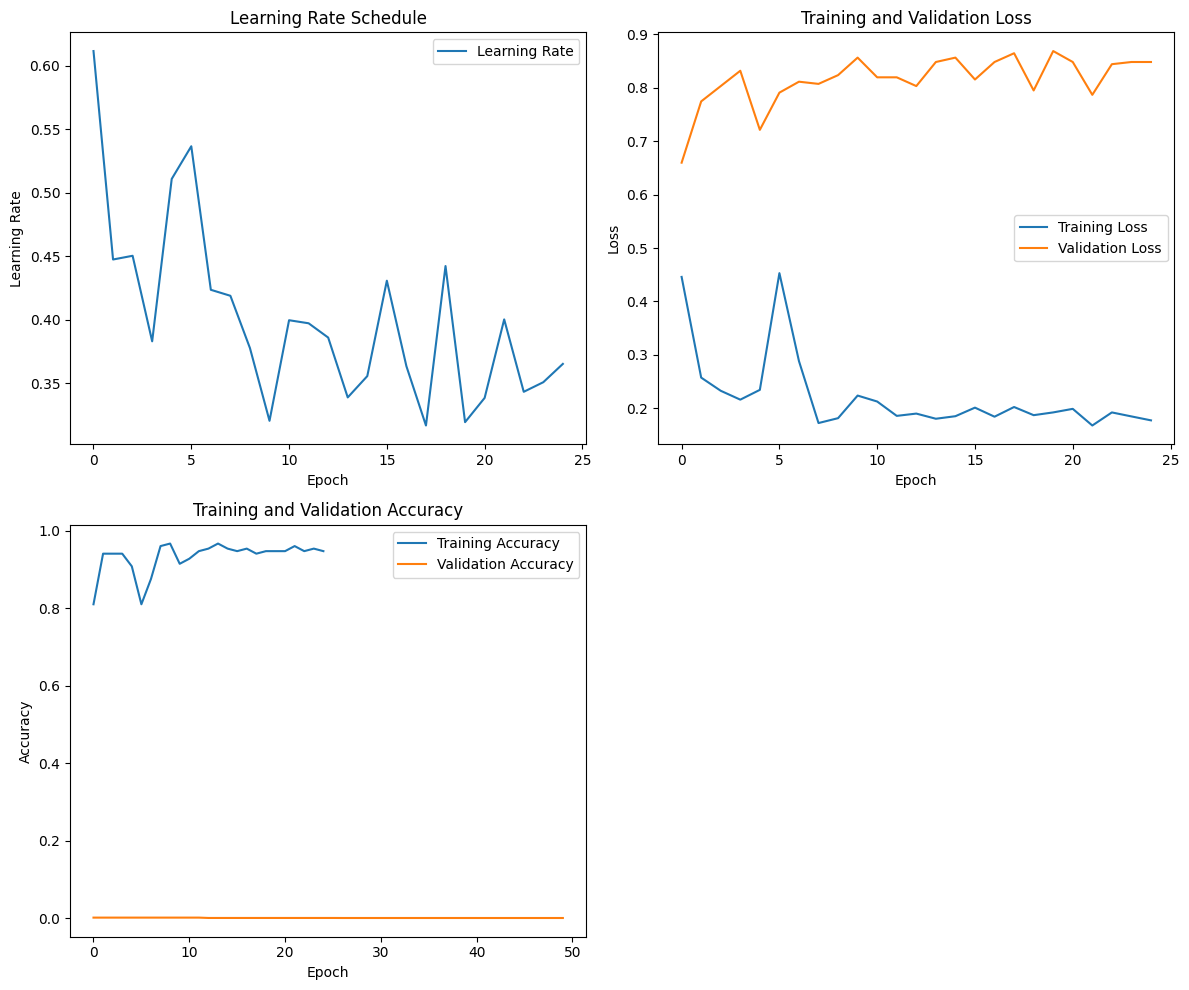

In [17]:

import matplotlib.pyplot as plt

def plot_training_history(lr_history, train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history):
    # 2x2 subplot grid
    plt.figure(figsize=(12, 10))

    # Create the first subplot for the learning rate
    plt.subplot(2, 2, 1)
    plt.plot(range(len(lr_history)), lr_history, label='Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.legend()

    # Create the second subplot for training and validation loss
    plt.subplot(2, 2, 2)
    plt.plot(range(len(train_loss_history)), train_loss_history, label='Training Loss')
    plt.plot(range(len(val_loss_history)), val_loss_history, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Create the third subplot for training and validation accuracy
    plt.subplot(2, 2, 3)
    plt.plot(range(len(train_accuracy_history)), train_accuracy_history, label='Training Accuracy')
    plt.plot(range(len(val_accuracy_history)), val_accuracy_history, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=25)

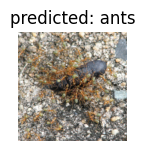

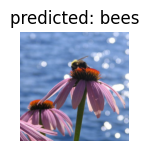

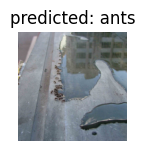

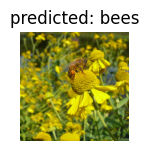

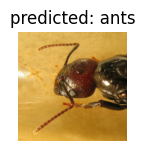

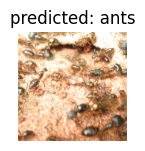

In [20]:
#시각화
visualize_model(model_conv)

plt.ioff()
plt.show()

## Inference on custom images

Use the trained model to make predictions on custom images and visualize
the predicted class labels along with the images.




In [18]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

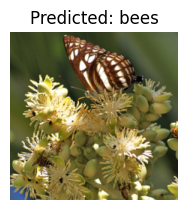

In [19]:
#시각화
visualize_model_predictions(
    model_conv,
    img_path='drive/MyDrive/hymenoptera_data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()

## Further Learning

If you would like to learn more about the applications of transfer learning,
checkout our [Quantized Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/intermediate/quantized_transfer_learning_tutorial.html).



